In [9]:
import sqlite3
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as ss

%matplotlib widget

In [10]:
results_db = 'results/out_1.2e-10_1.0e-01_True_6.0e+01_uniform.db'


In [11]:
dbcon = sqlite3.connect(results_db)
dbcur = dbcon.cursor()
res = dbcur.execute("SELECT * FROM sims").fetchall()


In [12]:
res_df = pd.DataFrame(res, columns=['sim_id', 'seed', 'timesteps', 'conflicts'])
# res_df = res_df[(res_df.index < 2e6) | (res_df.index > 99e6)].reset_index()

In [13]:
# res_df['conflicts'][res_df['conflicts'] > 1] = 1
res_df['conflicts'].value_counts()

0    599021
1       979
Name: conflicts, dtype: int64

In [14]:
res_df['cumul_conflicts'] = res_df.conflicts.cumsum()
res_df['timestep_hrs'] = res_df.timesteps/3600
res_df['cumul_timestep_hrs'] = res_df.timestep_hrs.cumsum()
res_df['umac_prob'] = res_df.cumul_conflicts/(res_df.index+1)
res_df['umac_rate'] = res_df.cumul_conflicts/res_df.cumul_timestep_hrs

n_sims = res_df.shape[0]
n_conflicts = res_df.conflicts.sum()

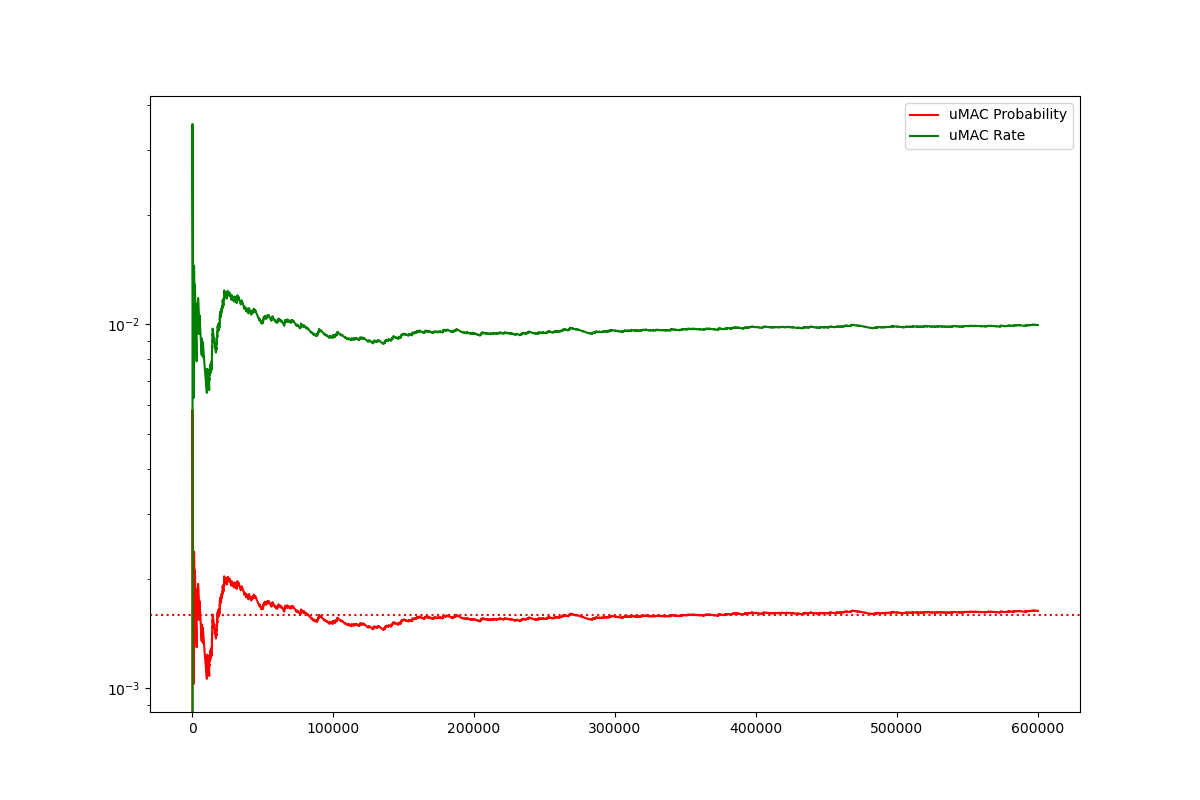

In [15]:
fig = plt.figure(figsize=(12,8))
ax = fig.subplots(1,1)
# ax.set_xscale('log')
ax.set_yscale('log')
res_df.umac_prob.plot(ax=ax, label='uMAC Probability', c='r')
res_df.umac_rate.plot(ax=ax, label='uMAC Rate', c='g')
ax.axhline(np.nanmedian(res_df.umac_prob), c='r', linestyle='dotted')
ax.legend()

In [38]:
# Work out variance fill betweens
p_confs = res_df.umac_prob.iloc[-1]
vars = (p_confs * (1 - p_confs)) / n_sims
lower_var = p_confs - vars
upper_var = p_confs + vars

In [39]:
res_df.conflicts.value_counts()

0    21000000
Name: conflicts, dtype: int64

In [40]:
n_conflicts

0

In [41]:
raw_sim_data = np.array(res, dtype=np.longlong)[:, 2:]

In [42]:
raw_sim_data.shape

(21000000, 2)

In [43]:
## Binomial distribution analysis
n_hits = raw_sim_data.sum(axis=0)[1]
n_trials = raw_sim_data.shape[0]
est_hit_prob = n_hits/n_trials

var = (est_hit_prob*(1-est_hit_prob))/n_trials
rel_err = np.sqrt(var)/est_hit_prob

# Using the Agresi-Coull method
sig_lvl = 0.05
z = 1-sig_lvl/2
p_til = (n_hits + (z*z)/2)/(n_trials + (z*z))
confidence_err = z*np.sqrt((p_til*(1-p_til))/(n_trials + (z*z)))
print(f'p={sig_lvl} value: {p_til:.3e} +/- {confidence_err} per operation')
print(f'Relative error: {rel_err*100:.4}%')

p=0.05 value: 2.263e-08 +/- 3.200920694426291e-08 per operation
Relative error: nan%


C:\Users\Aliak\AppData\Local\Temp\ipykernel_31612\151819396.py:7: RuntimeWarning: invalid value encountered in double_scalars
  rel_err = np.sqrt(var)/est_hit_prob
